# Setup Development Environment

In [2]:
%pip install  --upgrade \
  "transformers==4.44.2" \
  "datasets==2.21.0" \
  "evaluate==0.4.2"

  Using cached transformers-4.44.2-py3-none-any.whl.metadata (43 kB)
  Using cached datasets-2.21.0-py3-none-any.whl.metadata (21 kB)
  Using cached evaluate-0.4.2-py3-none-any.whl.metadata (9.3 kB)
  Using cached tokenizers-0.19.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached xxhash-3.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.18-py311-none-any.whl.metadata (7.5 kB)
  Using cached fsspec-2024.6.1-py3-none-any.whl.metadata (11 kB)
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.3 MB/s eta 0:00:00
   ━

# Load and prepare the dataset

In [3]:
def create_conversation(sample):
    system_message = """You are an text to SQL query translator. Users will ask you questions in English and you will generate a SQL query based on the provided SCHEMA. SCHEMA: {schema}"""
    return {
    "messages": [
      {"role": "system", "content": system_message.format(schema=sample["context"])},
      {"role": "user", "content": sample["question"]},
      {"role": "assistant", "content": sample["answer"]}
    ]
  }

In [4]:
from datasets import load_dataset

# Load dataset from the hub
seed = 42
dataset = load_dataset("b-mc2/sql-create-context", split="train")
dataset = dataset.shuffle(seed=seed).select(range(3000))
dataset[0]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/78577 [00:00<?, ? examples/s]

{'answer': 'SELECT venue FROM table_name_50 WHERE away_team = "essendon"',
 'question': 'When Essendon played away; where did they play?',
 'context': 'CREATE TABLE table_name_50 (venue VARCHAR, away_team VARCHAR)'}

In [5]:
dataset = dataset.map(create_conversation, batched=False)
dataset = dataset.remove_columns(["answer", "question", "context"])

dataset[0]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

{'messages': [{'content': 'You are an text to SQL query translator. Users will ask you questions in English and you will generate a SQL query based on the provided SCHEMA. SCHEMA: CREATE TABLE table_name_50 (venue VARCHAR, away_team VARCHAR)',
   'role': 'system'},
  {'content': 'When Essendon played away; where did they play?',
   'role': 'user'},
  {'content': 'SELECT venue FROM table_name_50 WHERE away_team = "essendon"',
   'role': 'assistant'}]}

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset

def calculate_token_lengths(sample, tokenizer):
    system_tokens = tokenizer(sample["messages"][0]["content"], truncation=False)['input_ids']
    prompt_tokens = tokenizer(sample["messages"][1]["content"], truncation=False)['input_ids']
    completion_tokens = tokenizer(sample["messages"][2]["content"], truncation=False)['input_ids']
    return {
        'system_tokens': len(system_tokens),
        'prompt_tokens': len(prompt_tokens),
        'completion_tokens': len(completion_tokens),
        'total_tokens': len(system_tokens) + len(prompt_tokens) + len(completion_tokens)
    }


def display_token_distribution_and_percentiles(dataset, tokenizer):
    token_lengths = dataset.map(lambda x: calculate_token_lengths(x, tokenizer), batched=False)

    lengths_dict = {
        'Prompt (Input)': np.array(token_lengths['prompt_tokens']),
        'Completion (Output)': np.array(token_lengths['completion_tokens']),
        'Combined (Input + Output)': np.array(token_lengths['total_tokens'])
    }

    plt.figure(figsize=(10, 8))
    for i, (label, lengths) in enumerate(lengths_dict.items(), 1):
        plt.subplot(len(lengths_dict.items()), 1, i)
        plt.hist(lengths, bins=50, alpha=0.7, label=label)
        plt.title(f'Token Length Distribution for {label}')
        plt.xlabel('Token Length')
        plt.ylabel('Frequency')
        plt.legend()

    plt.tight_layout()
    plt.show()

    def print_summary_statistics(data, label):
        print(f"\n{label} Token Length Summary:")
        df = pd.Series(data)
        print(df.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]))

    for label, lengths in lengths_dict.items():
        print_summary_statistics(lengths, label)

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

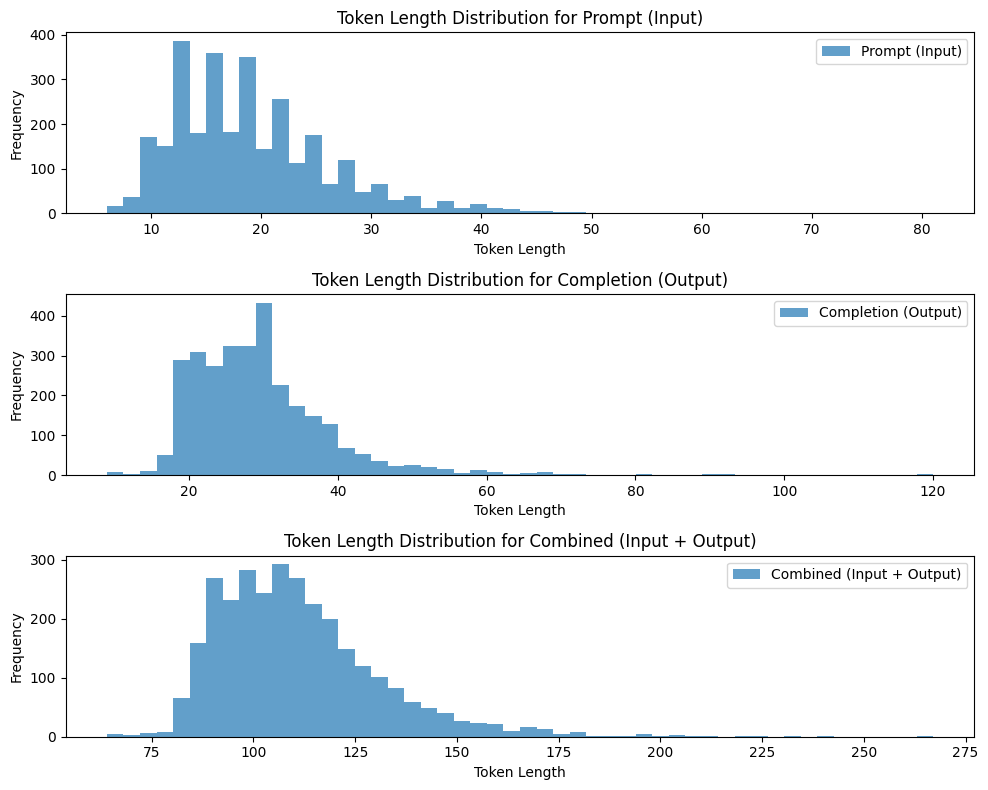


Prompt (Input) Token Length Summary:
count    3000.000000
mean       18.864000
std         7.326577
min         6.000000
50%        18.000000
75%        23.000000
90%        28.000000
95%        33.000000
99%        41.010000
max        81.000000
dtype: float64

Completion (Output) Token Length Summary:
count    3000.000000
mean       29.603000
std         9.879267
min         9.000000
50%        28.000000
75%        34.000000
90%        40.100000
95%        46.000000
99%        65.010000
max       120.000000
dtype: float64

Combined (Input + Output) Token Length Summary:
count    3000.000000
mean      111.025333
std        20.604131
min        64.000000
50%       108.000000
75%       120.000000
90%       137.000000
95%       149.000000
99%       178.000000
max       267.000000
dtype: float64


In [7]:
from transformers import AutoTokenizer

model_id = "HuggingFaceH4/zephyr-7b-beta"
tokenizer = AutoTokenizer.from_pretrained(model_id)
display_token_distribution_and_percentiles(dataset, tokenizer)

In [8]:
train_test_split = dataset.train_test_split(test_size=0.3, seed=seed)
val_test_split = train_test_split['test'].train_test_split(test_size=0.5, seed=seed)

dataset = {
    'train': train_test_split['train'],
    'val': val_test_split['train'],
    'test': val_test_split['test']
}

# Check the number of examples in each split
print(f"Training set size: {len(dataset['train'])}")
print(f"Validation set size: {len(dataset['val'])}")
print(f"Test set size: {len(dataset['test'])}")

Training set size: 2100
Validation set size: 450
Test set size: 450


In [9]:
# save train_dataset to s3 using our SageMaker session
data_input_path = f'./datasets/text-to-sql'

train_dataset_path = f"{data_input_path}/train/train_dataset.json"
eval_dataset_path = f"{data_input_path}/eval/eval_dataset.json"
test_dataset_path = f"{data_input_path}/test/test_dataset.json"

dataset["train"].to_json(train_dataset_path, orient="records")
dataset["val"].to_json(eval_dataset_path, orient="records")
dataset["test"].to_json(test_dataset_path, orient="records")

print(f"Training data uploaded to: {data_input_path}")

Creating json from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Training data uploaded to: ./datasets/text-to-sql
